In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865


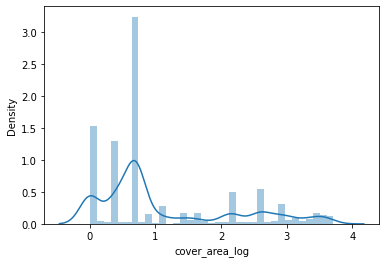

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [12]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [13]:
display(train[features])

,MIN_NIR_2020,MIN_CRI550_2002,MAX_Chlgreen_2014,MIN_Red_2019,MED_NIR_2020,MAX_SWIR2_2014,MIN_TIRS2_2015,MAX_DVIMSS_2002,MIN_Ferric_Oxides_2017,MIN_BWDRVI_2007,...,MED_TSAVI_2004,MED_Gossan_2006,MED_GARI_2002,MIN_GARI_2002,MAX_NormR_2007,MED_PPR_2014,MIN_DVI,MIN_D678_500_2009,MAX_Green_2007,MAX_SWIR2_2009
0,5.984110,NaN,8.636103,10.002676,6.068364,1.154654,8.246019,NaN,0.149268,-0.983075,...,-0.469875,0.143277,NaN,NaN,0.310083,-0.236400,0.181560,-32.928923,33.045624,0.108162
1,6.826641,NaN,8.053778,41.923199,45.608123,0.307106,7.799111,NaN,0.073818,-0.978992,...,NaN,0.053930,NaN,NaN,0.304827,-0.081340,0.605436,NaN,50.105415,NaN
2,4.022110,-0.009196,9.994777,33.453712,6.216788,0.475405,7.748652,0.085493,0.106665,-0.982066,...,-0.331796,0.082129,-0.157996,-0.157996,0.312516,-0.154707,0.791349,-40.991524,53.077557,3.833318
3,4.205594,NaN,6.696082,14.476292,5.304326,0.387846,7.919452,NaN,0.095888,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.215962,0.676392,NaN,NaN,NaN
4,4.386660,NaN,9.202839,11.728190,5.137692,0.309401,7.849276,NaN,0.115212,NaN,...,NaN,0.052650,NaN,NaN,NaN,-0.282158,0.785522,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,10.961229,-0.016588,4.024590,11.191984,19.593303,1.449885,7.566119,60.103551,0.108047,-0.966940,...,-0.214018,0.127727,-0.327534,-0.566515,0.312796,-0.249617,0.774556,-40.991901,37.341892,0.939699
14136,4.239558,NaN,10.033288,22.655863,4.757189,4.325888,7.882425,NaN,0.126104,NaN,...,NaN,0.114816,NaN,NaN,NaN,-0.152190,0.347254,NaN,NaN,NaN
14137,4.168425,NaN,9.667781,10.016207,4.657521,1.469533,7.847888,NaN,0.152980,NaN,...,-0.567568,0.046891,NaN,NaN,NaN,-0.196487,0.022190,-57.223625,NaN,0.656255
14138,18.529348,NaN,5.719629,89.414139,42.782887,1.671515,7.989658,NaN,0.105058,NaN,...,NaN,0.035153,NaN,NaN,NaN,-0.040283,0.153082,NaN,NaN,NaN


In [14]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [15]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [16]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [17]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [18]:
#!pip install iterative-stratification

In [19]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [20]:
class CFG:
  ver=22
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover_area_log"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover_area_log"
  fold_target3="cover_area_log"

In [21]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [22]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [23]:
features = list(features)
features.remove('id')
features.remove('area')

In [24]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [25]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [26]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

fold
0    5080
1    6853
2    4812
3    1434
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.400863


<ipython-input-25-3bef420f24b8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-25-3bef420f24b8>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.623344


<ipython-input-25-3bef420f24b8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-25-3bef420f24b8>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.792695


<ipython-input-25-3bef420f24b8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-25-3bef420f24b8>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.307761


<ipython-input-25-3bef420f24b8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-25-3bef420f24b8>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred


F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,feature,importance
138,Salinity_annual,0.066667
1334,sst_ymd,0.066667
2193,month,0.050000
591,year,0.050000
1935,hist_warm_sst,0.041667
249,lat,0.041667
482,river_dist,0.041667
1697,river_area,0.025000
1402,sst_diff,0.025000
1860,MAX_TIRS1_2017,0.025000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0


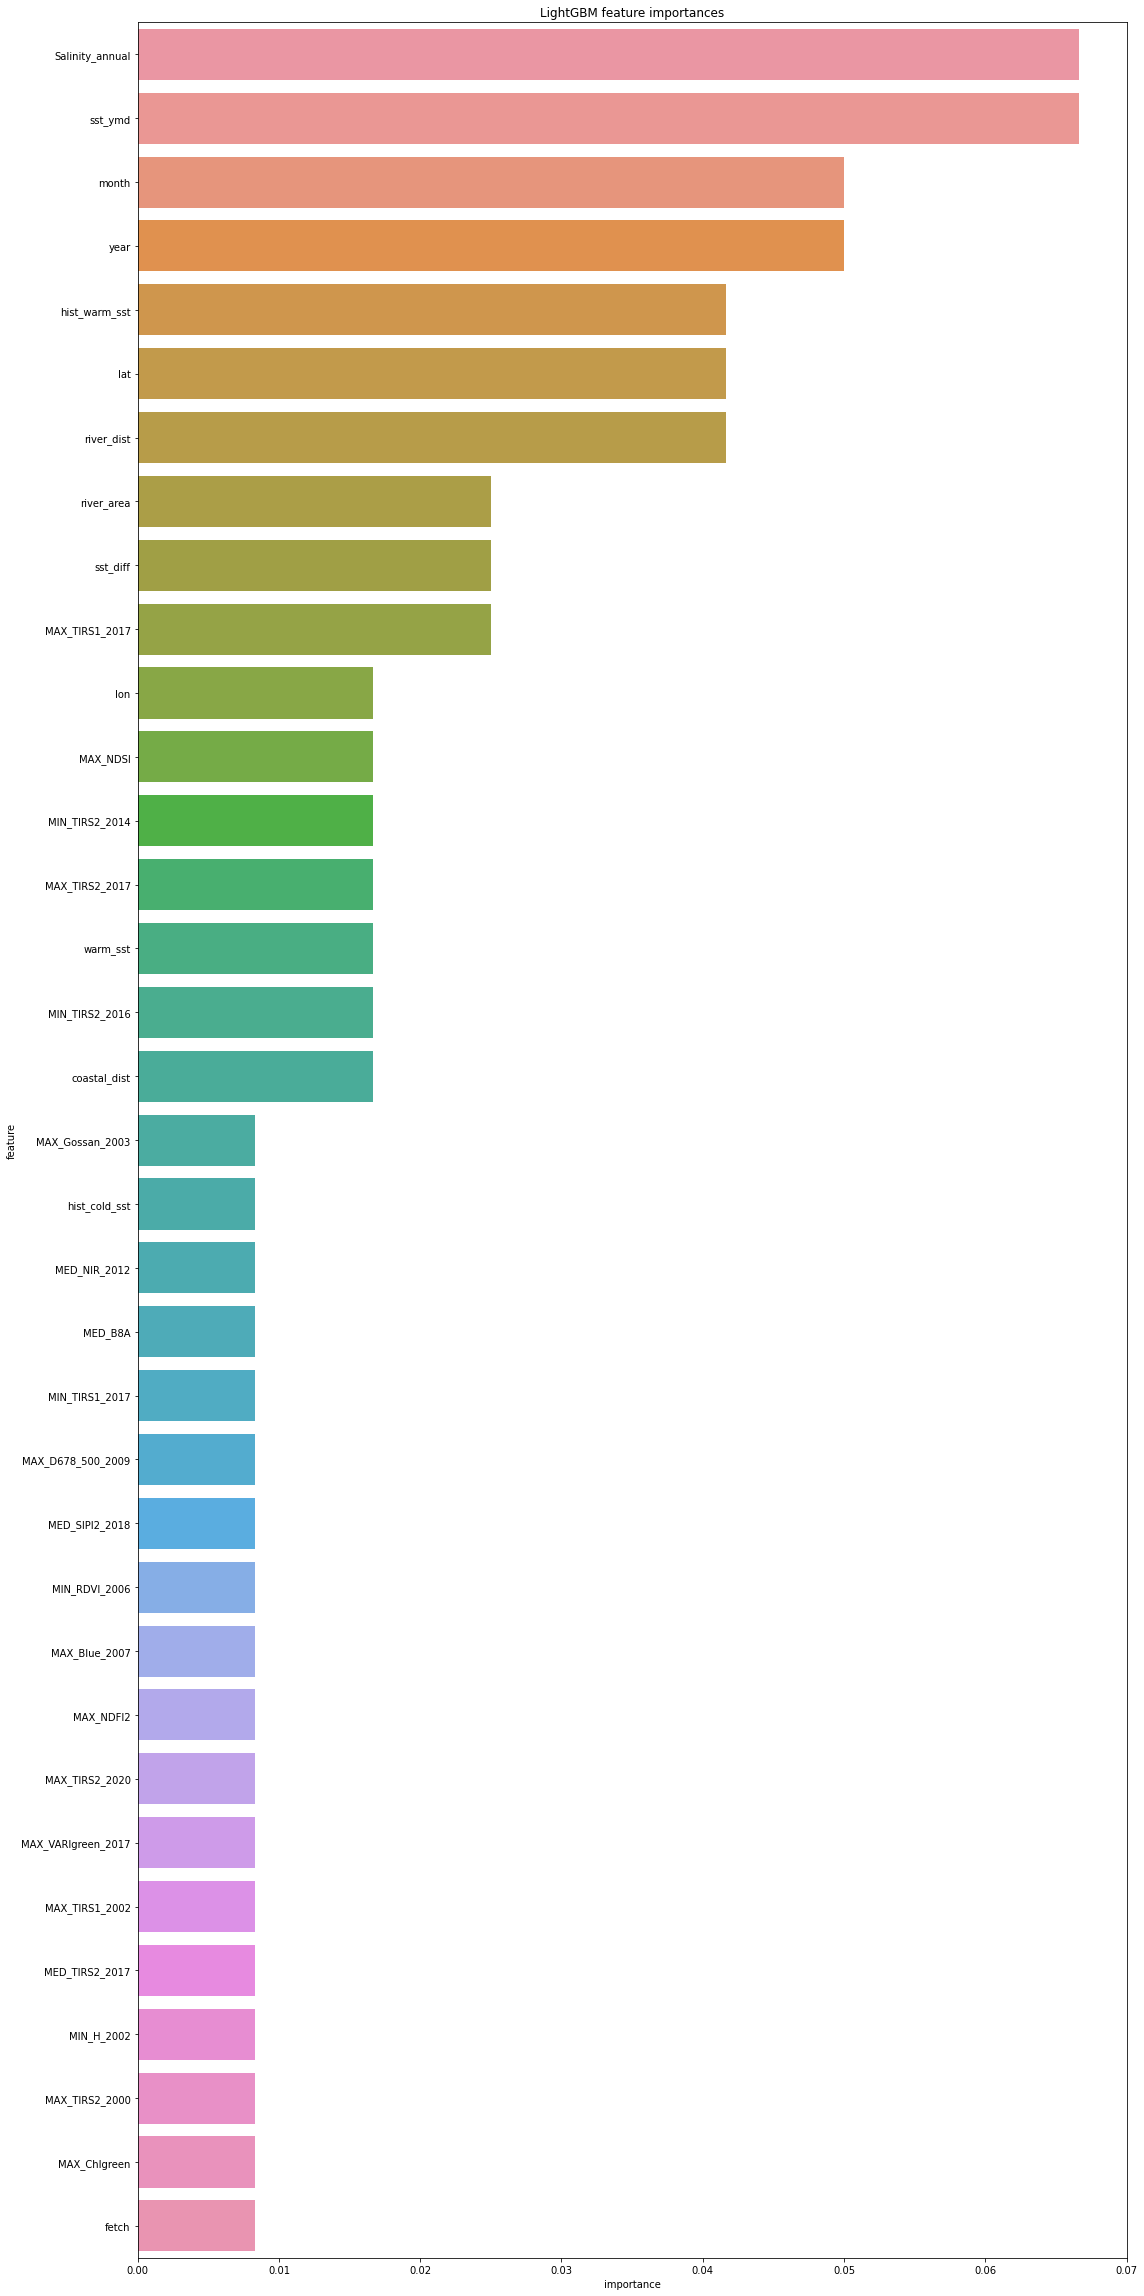

In [27]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [28]:
match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
display(match_results_df)

4039it [00:00, 23761.61it/s]

0.011295968057399602


,Tr,Ctl,Tr_zscore,Ctl_zscore,diff
0,1372,414,0.359670,0.360188,0.000518
1,397,29,0.281698,0.281698,0.000000
2,2625,51,0.281698,0.281698,0.000000
3,3179,263,0.281698,0.281698,0.000000
4,3050,359,0.281698,0.281698,0.000000
...,...,...,...,...,...
3620,2788,5812,0.153400,0.153400,0.000000
3621,587,5960,0.153400,0.153400,0.000000
3622,2118,5995,0.153400,0.153400,0.000000
3623,3081,6113,0.153400,0.153400,0.000000


In [29]:
match_id = match_results_df.Ctl.tolist()
match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
display(match_train)

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,cover_area,cover_area_log,adv_flag,mesh20_left,mesh20_right
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.000000,...,2.353039,95.142525,3.728732,-2.405135,3725_10,1.0,0.693147,0,3725,10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.000000,...,4.672225,174.767501,-0.571513,0.448861,4027_13,29.0,3.401197,0,4027,13
2,4,26.988254,127.917254,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.000000,...,2.436510,50.467718,8.537779,-1.617806,4027_13,9.0,2.302585,0,4027,13
3,6,26.490611,128.006361,20.0,20091214,2009.0,12.0,0.075,NaN,0.000000,...,2.927697,74.737237,5.043686,-4.875091,3928_20,1.5,0.916291,0,3928,20
4,7,24.291192,124.133547,20.0,NaN,2019.0,9.0,0.150,2.0,0.000000,...,2.379290,103.066745,4.072083,-39.851563,3624_10,3.0,1.386294,0,3624,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,13924,24.914528,125.280194,20.0,20110620,2011.0,6.0,0.100,NaN,0.000000,...,2.648713,74.396232,2.965612,-7.561698,3725_11,2.0,1.098612,0,3725,11
3621,13928,24.720611,125.471056,20.0,20110924,2011.0,9.0,0.050,NaN,646.281799,...,1.978987,71.157599,3.951208,-2.682321,3725_01,1.0,0.693147,0,3725,1
3622,13974,26.335092,127.934556,20.0,NaN,2019.0,8.0,0.875,-0.2,0.000000,...,2.839299,55.224489,2.067420,-6.839368,3927_23,17.5,2.917771,0,3927,23
3623,14009,26.343678,127.929145,20.0,NaN,2019.0,8.0,0.000,4.7,0.000000,...,2.371850,54.774450,3.963063,-12.699651,3927_23,0.0,0.000000,0,3927,23


fold
0    907
1    906
2    906
3    906
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.507553
Early stopping, best iteration is:
[331]	valid_0's rmse: 0.506712


<ipython-input-25-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.5067115536787615
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.429367
Early stopping, best iteration is:
[296]	valid_0's rmse: 0.428756


<ipython-input-25-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.4287558196189734
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.474761
Early stopping, best iteration is:
[322]	valid_0's rmse: 0.47424


<ipython-input-25-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.47423982064527964
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.453309
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.453197


<ipython-input-25-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.45319693678995226


,feature,importance
2193,month,0.005838
591,year,0.003747
1292,MAX_CI,0.003282
1334,sst_ymd,0.002904
237,MIN_mCRIRE_2020,0.002236
1847,MIN_GARI,0.002062
24,MAX_VARIgreen_2016,0.001975
2418,MIN_SWIR2_2008,0.001975
2621,MED_Datt1,0.001859
855,MAX_GVMI_2019,0.001859


RMSE 0.4666160353082764


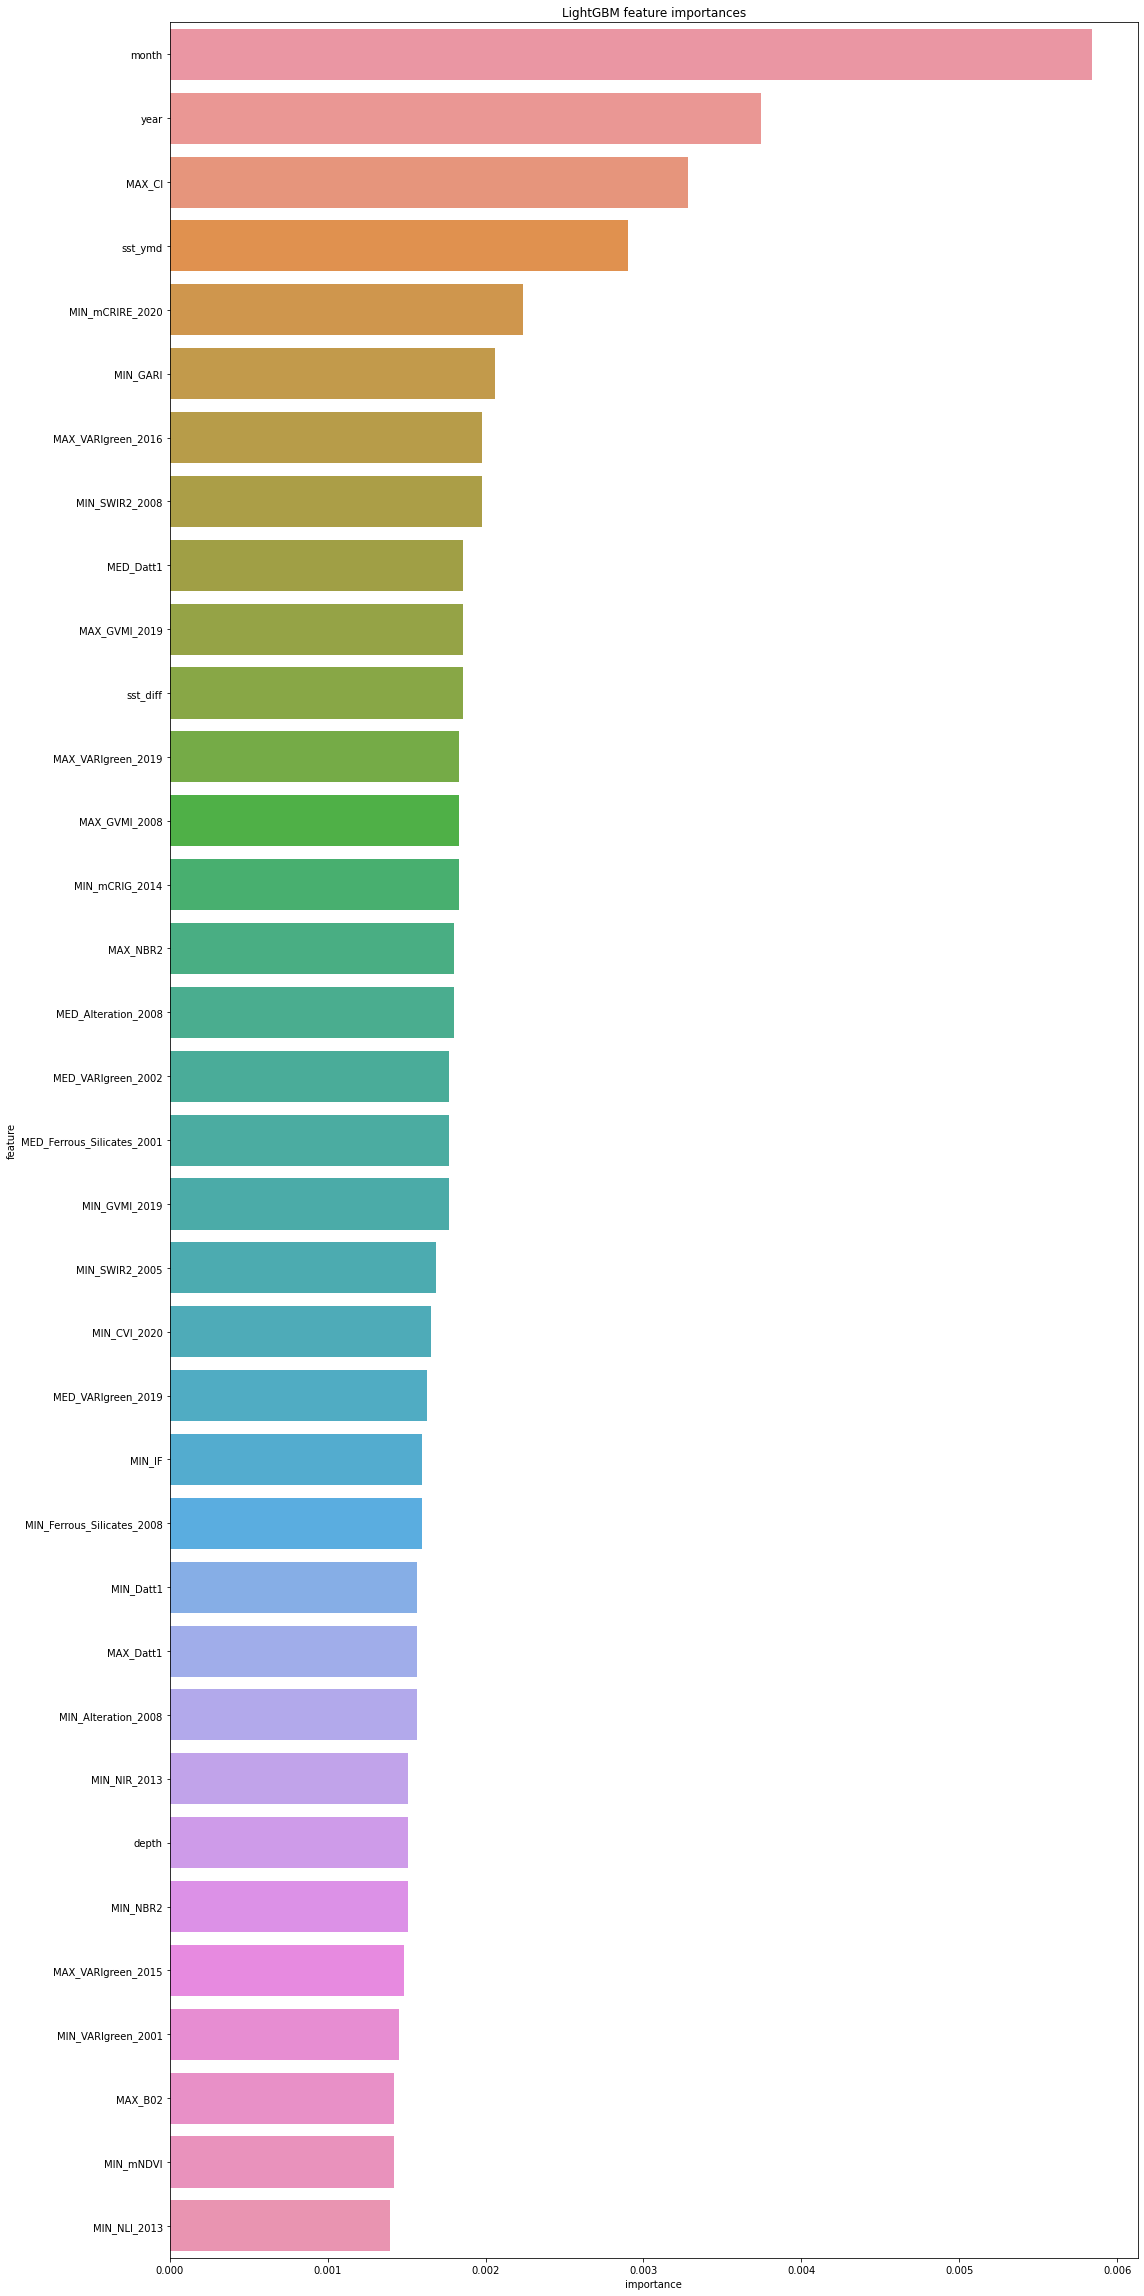

In [30]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(match_train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [31]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.expm1(_oof["_pred"]) / _oof["area"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.14190360559510337


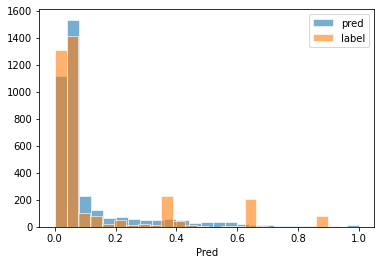

In [32]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [33]:
pred_df = test.copy()
pred_df["pred_area_log"] = np.mean(test_pred, axis=1)

pred_df["pred"] = np.expm1(pred_df["pred_area_log"]) / pred_df['area']
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.245351,0.013904
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.876143,0.070081
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.770358,0.011605
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.808897,0.062272
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.222529,0.119788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.805955,0.061942
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.803538,0.061671
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,1.566023,0.037876
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,1.032477,0.090401


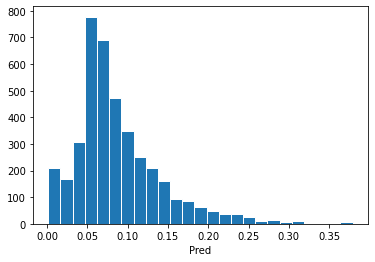

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.245351,0.013904
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.876143,0.070081
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.770358,0.011605
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.808897,0.062272
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.222529,0.119788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.805955,0.061942
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.803538,0.061671
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,1.566023,0.037876
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,1.032477,0.090401


In [34]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)